In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
%matplotlib inline

In [2]:
# load training and test data set from file
df = pd.read_csv("../data/Vowel.txt")

# rename classes to be from zero to 10
df.y = df.y - 1
features = [f'x.{i+1}' for i in range(10)]

# split data to training/test np.arrays
df_train, df_test = df[df.is_train==1], df[df.is_train==0]
X_train, y_train = df_train[features].values, df_train.y.values
X_test, y_test = df_test[features].values, df_test.y.values

<h2>Linear Regression of an Indicator Matrix</h2>

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [4]:
# PAGE 103. Here each of the response categories are coded via an indicator variable.
#           Thus if G has K classes, there will be K such indicators Yk, k = 1,...,K,
#           with Yk = 1 if G = k else 0. These are collected together in a vector
#           Y = (Y1,...,Yk), and the N training instances of these form an N x K
#           indicator response matrix Y.
Y_train_one_hot = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()

# PAGE 103. We fit a linear regression model to each of the columns of Y simultaneously
reg = LinearRegression().fit(X_train, Y_train_one_hot)

# PAGE 103. identify the largest component and classify accordingly;
y_train_hat = np.argmax(reg.predict(X_train), axis=1)
y_test_hat = np.argmax(reg.predict(X_test), axis=1)

# PAGE 106. There are K = 11 classes in p = 10 dimensions.
#           This is a difficult classification problem, and the best methods achieve
#           around 40% errors on the test data. The main point here is summarized in
#           Table 4.1; linear regression has an error rate of 67%, while a close relative,
#           linear discriminant analysis, has an error rate of 56%. It seems that masking
#           has hurn in this case. While all the other methods in this chapter are based
#           on linear functions of x as well, they use them in such a way that avoids
#           this masking problem.
lin_train_error = 1 - accuracy_score(y_train, y_train_hat)
lin_test_error = 1 - accuracy_score(y_test, y_test_hat)
print(f'Linear regression {lin_train_error:.2f} {lin_test_error:.2f}')

Linear regression 0.48 0.67


<h2>Linear Discriminant Analysis</h2>

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [6]:
lda = LinearDiscriminantAnalysis(n_components=2).fit(X_train, y_train)
lda_train_error = 1 - accuracy_score(y_train, lda.predict(X_train))
lda_test_error = 1 - accuracy_score(y_test, lda.predict(X_test))
print(f'Linear discriminant analysis {lda_train_error:.2f} {lda_test_error:.2f}')

Linear discriminant analysis 0.32 0.56


Text(0,0.5,'Coordinate 2 for Training Data')

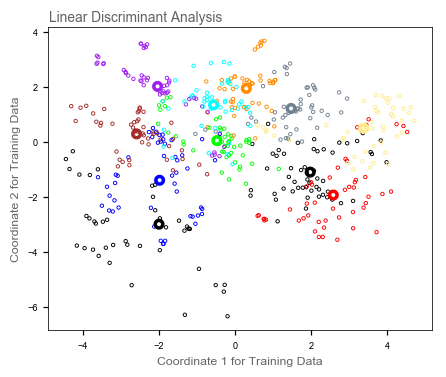

In [7]:
# PAGE 107. Figure 4.4. A two-dimensional plot of the vowel training data. There are
#           eleven classes with X in R^10, and this is the best view in terms of LDA model
#           (Section 4.3.3). The heavy circles are the projected means vectors for each
#           classes. The class overlap is considerable.
X_r = lda.transform(X_train)
means = lda.transform(lda.means_)

# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY4 = '#646369'
colors = np.array(['#000000', '#0000FF', '#A52A2A', '#A020F0', '#FF8C00', '#00FFFF',
                   '#708090', '#FFEC8B', '#000000', '#FF0000', '#00FF00'])
fig, ax1 = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax1.scatter(X_r[:, 0], X_r[:, 1], facecolors='none', edgecolors=colors[y_train], 
            s=5, linewidth=0.6)
ax1.scatter(means[:, 0], means[:, 1], facecolors='none', edgecolors=colors, 
            s=5, linewidth=5)
for i in ax1.get_yticklabels() + ax1.get_xticklabels():
    i.set_fontsize(6)
ax1.text(-4.89, 4.4, 'Linear Discriminant Analysis', color=GRAY4, fontsize=9)
ax1.set_xlabel('Coordinate 1 for Training Data', color=GRAY4, fontsize=8)
ax1.set_ylabel('Coordinate 2 for Training Data', color=GRAY4, fontsize=8)

<h2>Quadratic Discriminant Analysis</h2>

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [9]:
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_train_error = 1 - accuracy_score(y_train, qda.predict(X_train))
qda_test_error = 1 - accuracy_score(y_test, qda.predict(X_test))
print(f'Quadratic discriminant analysis {qda_train_error:.2f} {qda_test_error:.2f}')

Quadratic discriminant analysis 0.01 0.53


<h2>Logistic Regression</h2>

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [11]:
lr = LogisticRegression(C=10e10).fit(X_train, y_train)
lr_train_error = 1 - accuracy_score(y_train, lr.predict(X_train))
lr_test_error = 1 - accuracy_score(y_test, lr.predict(X_test))
print(f'Logistic Regression {lr_train_error:.2f} {lr_test_error:.2f}')

Logistic Regression 0.34 0.59


In [12]:
# PAGE 107. TABLE 4.1. Training and test error rates using a variety of linear techniques
#           on the vowel data. There are eleven classes in ten dimensions, of which three
#           account for 90% of the variance (via a principal component analysis). We see
#           that linear regression is hurt by masking, increasing the test and training error
#           by over 10%.
print(' ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟')
print('                      Technique  ͟ ͟ ͟ ͟E͟r͟r͟o͟r͟ ͟R͟a͟t͟e͟s͟ ͟ ͟ ͟')
print(' ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟T͟r͟a͟i͟n͟i͟n͟g͟ ͟ ͟ ͟T͟e͟s͟t͟ ͟')
print(f'              Linear regression   {lin_train_error:.2f}       {lin_test_error:.2f}')
print(f'   Linear discriminant analysis   {lda_train_error:.2f}       {lda_test_error:.2f}')
print(f'Quadratic discriminant analysis   {qda_train_error:.2f}       {qda_test_error:.2f}')
print(f'      Logistic regression (???)   {lr_train_error:.2f}       {lr_test_error:.2f}')
print(f'___________________________________________________')

 ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟
                      Technique  ͟ ͟ ͟ ͟E͟r͟r͟o͟r͟ ͟R͟a͟t͟e͟s͟ ͟ ͟ ͟
 ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟ ͟T͟r͟a͟i͟n͟i͟n͟g͟ ͟ ͟ ͟T͟e͟s͟t͟ ͟
              Linear regression   0.48       0.67
   Linear discriminant analysis   0.32       0.56
Quadratic discriminant analysis   0.01       0.53
      Logistic regression (???)   0.34       0.59
___________________________________________________
